# NYC Crime Data Analysis

**Motivation:**

NYPD has provided statistics on the crime (by precinct) for several years. This is an important resource to understand and analyze urban crime. There are obvious connections between crime and wealth, which relate both to access to precious goods, and to how easy it is to commit a crime (the neighborhood safety, or perceived safety). [It has been suggested](https://journalistsresource.org/studies/government/criminal-justice/unemployment-property-crime-burglary) that unemployment correlates strongly with burglary for example, due to both opportunity and motivation. In addition there are [several pieces of research](https://www.citylab.com/solutions/2016/04/vacant-lots-green-space-crime-research-statistics/476040/) that indicate that access to green spaces affects crime.

In this study we explore the crime in NYC from both temporal and spatial domains:

- Exploratory analysis of the crime time series for the seven major felonies 2000-2016 (temporal domain).

- Analyze the relationship between socioeconomic features to individual crime rates by area (spatial domain).

In [1]:
from __future__ import print_function
import pylab as plt
import pandas as pd
import numpy as np

import io
import os
import sys
import json
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import geopandas as gpd
#import zipfile 
import urllib
import statsmodels.api as sm
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from scipy.spatial.distance import cdist, pdist
from sklearn import cluster
from sklearn import preprocessing
import statsmodels.formula.api as smf    # for OLS regression
from sklearn import cross_validation 
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
#from sklearn.metrics import silhouette_samples, silhouette_score
#import matplotlib.cm as cm
#import scipy.cluster as scp
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# 1. Time domain exploratory analysis

## 1.1 obtain historical data for 2000-2016 for all NYC police precincts

In [2]:
!wget https://www1.nyc.gov/assets/nypd/downloads/excel/analysis_and_planning/seven-major-felony-offenses-by-precinct-2000-2016.xls

--2017-12-17 23:31:57--  https://www1.nyc.gov/assets/nypd/downloads/excel/analysis_and_planning/seven-major-felony-offenses-by-precinct-2000-2016.xls
Resolving www1.nyc.gov... 104.106.240.221, 2600:141b:13:297::1500, 2600:141b:13:292::1500
Connecting to www1.nyc.gov|104.106.240.221|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125952 (123K) [application/vnd.ms-excel]
Saving to: “seven-major-felony-offenses-by-precinct-2000-2016.xls”

100%[======================================>] 125,952     --.-K/s   in 0.006s  

2017-12-17 23:31:57 (19.0 MB/s) - “seven-major-felony-offenses-by-precinct-2000-2016.xls” saved [125952/125952]



In [3]:
os.system("mv seven-major-felony-offenses-by-precinct-2000-2016.xls " + os.getenv("PUIDATA"))

0

In [4]:
crimedata = pd.read_excel(os.getenv("PUIDATA") + "/seven-major-felony-offenses-by-precinct-2000-2016.xls", skiprows=2)

In [5]:
crimedata.iloc[range(592,600,1)]

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
592,121,MURDER & NON NEGL. MANSLAUGHTER ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,0.0,9.0
593,NaN,RAPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,12.0,13.0,19.0
594,NaN,ROBBERY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.0,151.0,138.0,120.0
595,NaN,FELONY ASSAULT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,225.0,248.0,190.0
596,NaN,BURGLARY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.0,134.0,166.0,137.0
597,NaN,GRAND LARCENY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,215.0,393.0,430.0,397.0
598,NaN,GRAND LARCENY OF MOTOR VEHICLE ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,60.0,74.0,63.0
599,NaN,TOTAL SEVEN MAJOR FELONY OFFENSES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,548.0,979.0,1069.0,935.0


If we use fillna(ffill method) to the dataset, all the crime number that is NaN in PCT 121 will be filled with a large number, that turn the PCT 121 into a outlier. Therefore in time series analyis, I will drop the PCT 121 since there is no data before 2013. But in later analysis using the mean of crime numbers, I will use the mean of 2013 to 2016 instead for PCT 121.

In [6]:
crime = crimedata.fillna(method='ffill') 

In [7]:
crime.describe()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
count,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000
mean,630.188679,554.213836,527.141509,499.028302,483.877358,466.738994,441.257862,417.588050,408.408805,367.578616,361.676101,368.927673,386.603774,361.996855,343.396226,338.764151,329.465409
std,886.138426,790.743142,739.370608,697.085017,675.478938,638.157402,602.084727,571.483049,556.479626,505.148518,495.912139,504.452529,533.872234,509.611397,489.177964,482.938947,473.514493
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,75.500000,70.500000,74.500000,61.750000,56.750000,54.000000,43.500000,43.750000,42.250000,36.000000,35.000000,34.000000,33.000000,29.750000,28.750000,29.750000,28.000000
50%,361.000000,315.500000,305.500000,277.500000,279.000000,275.500000,254.000000,228.000000,222.500000,208.000000,196.500000,200.500000,205.000000,177.000000,169.500000,163.500000,141.500000
75%,648.250000,581.000000,561.500000,524.750000,496.250000,514.250000,475.000000,475.000000,460.000000,414.000000,396.250000,413.000000,435.000000,415.000000,413.000000,379.000000,425.250000
max,6857.000000,6088.000000,5265.000000,5105.000000,4730.000000,4423.000000,4173.000000,3971.000000,3708.000000,3330.000000,3103.000000,3393.000000,3780.000000,3902.000000,3751.000000,3506.000000,3287.000000


## 1.2 remove outliers

In [8]:
#remove rows that are not for a precinct (all precincts are identified by numbers)
crime = crime[(crime['PCT'] > 0) & (crime['PCT'] < 124)]

In [9]:
crime.head(3)

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,1,MURDER & NON NEGL. MANSLAUGHTER ...,3.0,1.0,2.0,2.0,2.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1,RAPE,12.0,5.0,10.0,11.0,11.0,5.0,4.0,7.0,12.0,4.0,6.0,13.0,10.0,12.0,8.0,7.0,9.0
2,1,ROBBERY,252.0,188.0,210.0,164.0,154.0,172.0,119.0,128.0,108.0,106.0,96.0,102.0,81.0,68.0,50.0,79.0,60.0


As mentioned above, after fillna, the PCT 121 has very large number which make it an outlier. Below I used the first categray of crimes to identify the oulier. Then drop PCT 121 for time series analyis.

In [10]:
# first group of crime categray
est = crime.as_matrix(columns=crime.columns[2:])
group1 = est[range(0,616,8)]
group1.shape

(77, 17)

In [11]:
group1mean = np.mean(group1, axis=1)
np.where(group1mean > np.mean(group1mean) + 3 * np.std(group1mean))

(array([74]),)

In [12]:
print("The PCT of outlier is %s"%crime.iloc[[74*8],:]['PCT'].values)

The PCT of outlier is [121]


In [13]:
crime = crime[~(crime.PCT == 121)]
crime.reset_index(inplace=True, drop=True) 
crime.head()

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,1,MURDER & NON NEGL. MANSLAUGHTER ...,3.0,1.0,2.0,2.0,2.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1,RAPE,12.0,5.0,10.0,11.0,11.0,5.0,4.0,7.0,12.0,4.0,6.0,13.0,10.0,12.0,8.0,7.0,9.0
2,1,ROBBERY,252.0,188.0,210.0,164.0,154.0,172.0,119.0,128.0,108.0,106.0,96.0,102.0,81.0,68.0,50.0,79.0,60.0
3,1,FELONY ASSAULT,139.0,164.0,147.0,134.0,129.0,121.0,94.0,90.0,83.0,83.0,68.0,94.0,110.0,87.0,76.0,86.0,78.0
4,1,BURGLARY,475.0,437.0,297.0,403.0,246.0,293.0,255.0,231.0,189.0,207.0,170.0,155.0,188.0,171.0,145.0,138.0,117.0


## 1.3  Plot the time series for each of the seven major felonies and for the total (aggregation of all felonies). 

In [14]:
crimet = crime.T
crimet = crimet.drop(['PCT', 'CRIME'])
crimet.head()

,0,1,2,3,4,5,6,7,8,9,...,598,599,600,601,602,603,604,605,606,607
2000,3,12,252,139,475,2358,199,3438,4,9,...,667,1692,2,3,35,67,162,101,266,636
2001,1,5,188,164,437,2117,157,3069,3,3,...,532,1434,2,2,30,57,140,90,193,514
2002,2,10,210,147,297,1896,153,2715,0,12,...,386,1354,0,4,29,50,153,116,143,495
2003,2,11,164,134,403,1803,132,2649,3,7,...,288,1252,1,4,33,49,112,137,131,467
2004,2,11,154,129,246,1708,133,2383,1,7,...,257,1356,1,3,29,56,114,166,95,464


In [15]:
crimetype = ['MURDER & NON NEGL. MANSLAUGHTER', 'RAPE', 'ROBBERY', 'FELONY ASSAULT', 'BURGLARY', 'GRAND LARCENY',\
             'GRAND LARCENY OF MOTOR VEHICLE', 'TOTAL SEVEN MAJOR FELONY OFFENSES']

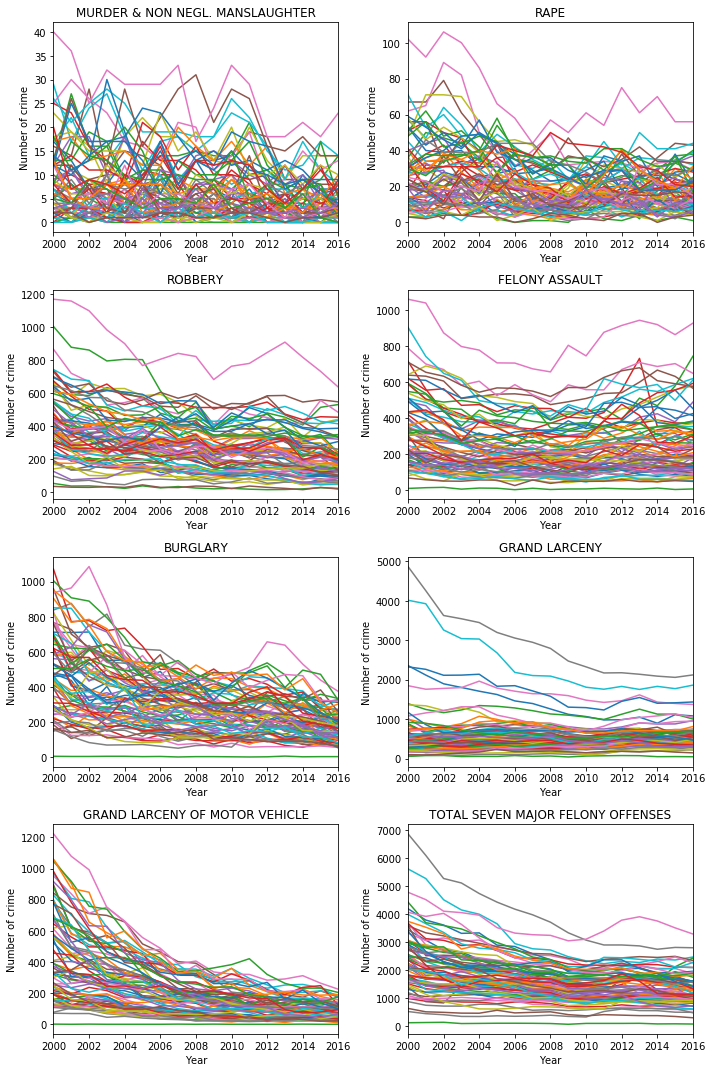

In [16]:
fig = plt.figure(figsize=(10,15))
for i in range(8):
    ax = fig.add_subplot(4,2,i+1)
    crimet.plot(y = range(i,i+608,8), legend = False, ax=ax)
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of crime")
    ax.set_title(crimetype[i])
plt.tight_layout()

### Figure 1. Time series for each of the seven major felonies and for the total from 2000 to 2016 for different precincts in NYC. For crime type of murder, rape, robbery and assault, the number fluctuate over the years. For burglary, larceny, larceny of vehicle and totol number of crimes, the number is decreasing in most precincts over the years.

## 1.4 calculate the mean and standard deviation in time for each precinct and each crime

In [17]:
df_ = pd.DataFrame()
df_['PCT'] = crime['PCT']
df_['CRIME'] = crime['CRIME']
df_['mean'] = crime.mean(axis=1).values
df_['std'] = crime.std(axis=1).values
df_.head()

,PCT,CRIME,mean,std
0,1,MURDER & NON NEGL. MANSLAUGHTER ...,1.058824,0.966345
1,1,RAPE,8.588235,3.063063
2,1,ROBBERY,125.705882,56.514118
3,1,FELONY ASSAULT,104.882353,28.676825
4,1,BURGLARY,242.176471,107.459431


In [18]:
df121 = crimedata.iloc[range(592,600,1)]
df121['mean'] = crimedata.mean(axis=1).values[range(592,600,1)]
df121['std'] = crimedata.std(axis=1).values[range(592,600,1)]
df121 = df121.loc[:, [ 'PCT', 'CRIME', 'mean', 'std']]
df121 = df121.fillna(method='ffill') 
df121.reset_index(inplace=True, drop=True) 
df121.head()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,PCT,CRIME,mean,std
0,121,MURDER & NON NEGL. MANSLAUGHTER ...,3.50,4.041452
1,121,RAPE,13.25,4.193249
2,121,ROBBERY,127.00,22.583180
3,121,FELONY ASSAULT,190.00,66.427906
4,121,BURGLARY,134.00,27.434771


In [19]:
# Add mean and std for PCT 121.
df1 = pd.concat([df_, df121])
df1.reset_index(inplace=True, drop=True) 

In [20]:
df1.head()

,PCT,CRIME,mean,std
0,1,MURDER & NON NEGL. MANSLAUGHTER ...,1.058824,0.966345
1,1,RAPE,8.588235,3.063063
2,1,ROBBERY,125.705882,56.514118
3,1,FELONY ASSAULT,104.882353,28.676825
4,1,BURGLARY,242.176471,107.459431


### quantitative analysis of these time series (trends, periodicity etc.).

In [21]:
crimet.head()

,0,1,2,3,4,5,6,7,8,9,...,598,599,600,601,602,603,604,605,606,607
2000,3,12,252,139,475,2358,199,3438,4,9,...,667,1692,2,3,35,67,162,101,266,636
2001,1,5,188,164,437,2117,157,3069,3,3,...,532,1434,2,2,30,57,140,90,193,514
2002,2,10,210,147,297,1896,153,2715,0,12,...,386,1354,0,4,29,50,153,116,143,495
2003,2,11,164,134,403,1803,132,2649,3,7,...,288,1252,1,4,33,49,112,137,131,467
2004,2,11,154,129,246,1708,133,2383,1,7,...,257,1356,1,3,29,56,114,166,95,464


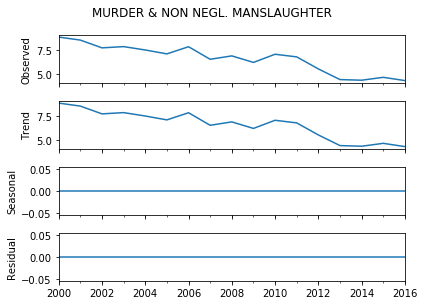

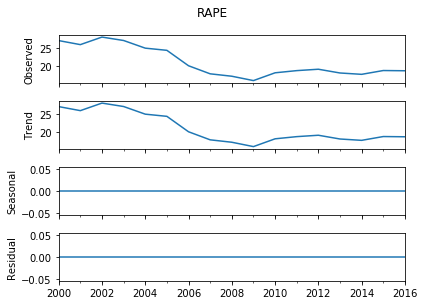

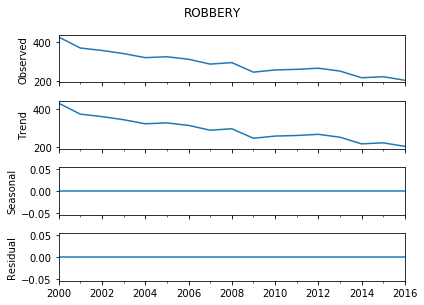

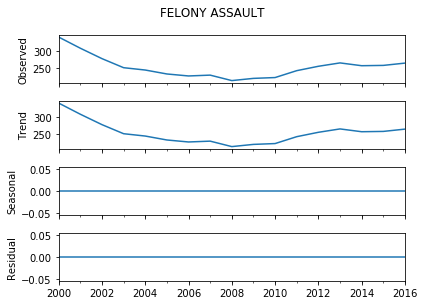

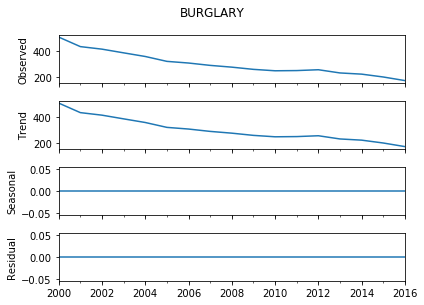

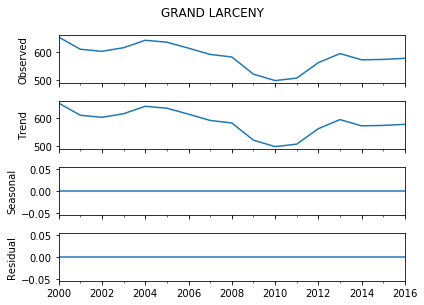

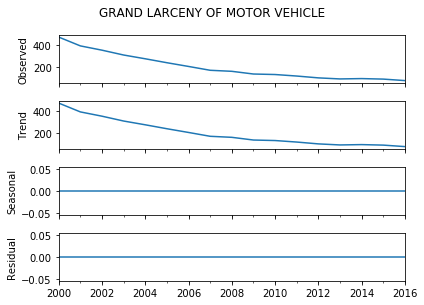

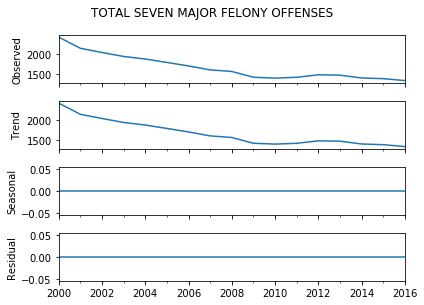

In [22]:
for i in range(8):
    #fig = plt.figure(figsize=(10,6))
    group = crimet.iloc[:,range(i,608,8)]
    group.index = pd.to_datetime(group.index, format='%Y')
    #Create a yearly time series
    df_new = group.mean(1).resample('A').mean()
    df_new.interpolate(inplace=True)
    #Seasonal Decomposition using statsmodels api
    res = sm.tsa.seasonal_decompose(df_new.dropna())
    plt.rcParams['figure.figsize']=(6,4)
    resplot = res.plot()
    plt.suptitle(crimetype[i], y=1.05)    

### Figure 2. Seasonal decomposition of time series of the seven major felonies and for the total from 2000 to 2016. Each time series are decomposed into three parts of trend, periodicity and residual. The plots show that except for assault and larceny, most of the trend is downward. There is no obvious seasonal periodicity observed.

## 1.5 extract the total crime row for each precinct and cluster the time series. 

In [23]:
totcrime = crime.iloc[range(7,608,8)]

In [24]:
totcrime.head(3)

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
7,1,TOTAL SEVEN MAJOR FELONY OFFENSES,3438.0,3069.0,2715.0,2649.0,2383.0,2305.0,2013.0,1914.0,1708.0,1578.0,1445.0,1402.0,1416.0,1416.0,1208.0,1446.0,1395.0
15,5,TOTAL SEVEN MAJOR FELONY OFFENSES,1780.0,1458.0,1309.0,1231.0,1170.0,1131.0,1040.0,1031.0,1029.0,975.0,969.0,962.0,1001.0,980.0,870.0,917.0,899.0
23,6,TOTAL SEVEN MAJOR FELONY OFFENSES,2387.0,2141.0,2059.0,2068.0,2174.0,2055.0,1979.0,1837.0,1738.0,1633.0,1530.0,1504.0,1574.0,1703.0,1575.0,1521.0,1388.0


In [25]:
est1 = totcrime.as_matrix(columns=crime.columns[2:])

In [26]:
est1

array([[ 3438.,  3069.,  2715., ...,  1208.,  1446.,  1395.],
       [ 1780.,  1458.,  1309., ...,   870.,   917.,   899.],
       [ 2387.,  2141.,  2059., ...,  1575.,  1521.,  1388.],
       ..., 
       [ 2347.,  2048.,  1968., ...,  1165.,  1147.,  1131.],
       [ 1692.,  1434.,  1354., ...,   720.,   671.,   736.],
       [  636.,   514.,   495., ...,   378.,   348.,   302.]])

In [27]:
vals = ((est1.T - est1.mean(1))/est1.std(1)).T

In [28]:
print("I expect means of each row to be = 0", vals.mean(1)[:10])
print("I expect stds of each row to be = 1", vals.std(1)[:10])

I expect means of each row to be = 0 [  1.63268092e-16   2.80821118e-16  -3.13474736e-16  -2.61228947e-16
   9.79608551e-17   4.04904868e-16   2.08983158e-16  -1.43675921e-16
   1.11022302e-16  -1.30614473e-17]
I expect stds of each row to be = 1 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


### Explore the guess for k (the optimal number of clusters for K-means clustering) by first using silhouette_score and then the Elbow method.

In [29]:
#from sklearn.metrics import silhouette_samples, silhouette_score
#import matplotlib.cm as cm
X = vals
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.431408377324
For n_clusters =3, the average silhouette_score is :0.375014396493
For n_clusters =4, the average silhouette_score is :0.225484075027
For n_clusters =5, the average silhouette_score is :0.234454198184
For n_clusters =6, the average silhouette_score is :0.247838378938
For n_clusters =7, the average silhouette_score is :0.148549696537
For n_clusters =8, the average silhouette_score is :0.205173392515
For n_clusters =9, the average silhouette_score is :0.151609028605


### Discussion: The average silhouette score close to 1 mean that the points are usually much closer to their cluster centroids than to all the other ones (i.e. clustered appropriately). From the results, we found that when the number of clusters equal to 2, the average silhouette_score is the largest. But it may also because the cluster pattern is not very clear. Let's try the elbow method.

In [30]:
#from scipy.spatial.distance import cdist, pdist
def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

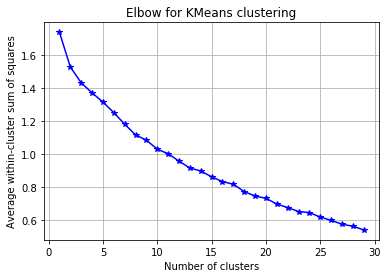

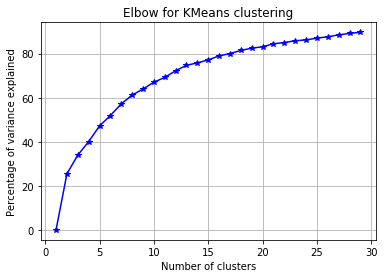

In [31]:
elbow(X, range(1,30))

### Figure 3. Elbow for Kmeans clustering.

### The Elbow method looks at the percentage of variance explained as a function of the number of clusters. The idea of the elbow method is to choose the k at which the sum of squared error (SSE) decreases abruptly. This produces an "elbow effect" in the graph. From the plots, I kind of didn't find a very clear point when the SSE decreases abruptly. Here for explornary analysis, I decide to try with clusters equal to 2, 4, 7.

In [32]:
# a function to plot clusters using k means
def plotkmeans(n):
    km = KMeans(random_state=999,n_clusters=n)
    rr = km.fit(vals)
    cent = km.cluster_centers_
    totcrime['Kmeans{}'.format(n)] = rr.labels_
    fig = plt.figure(figsize=(10, 25))
    for i in range(n):
        ax = fig.add_subplot(5,2,i+1)
        for j in range(len(vals)):
            if rr.labels_[j] == i:
                plt.plot(np.arange(2000, 2017, 1), vals[j], alpha = 0.5, lw = 2, color = 'grey')
        plt.plot(np.arange(2000, 2017, 1), cent[i], color='b', lw=5)
        ax.set_xlim(2000, 2016)
        ax.set_yticklabels(['' * len(ax.get_xticklabels())])
        #ax.set_axis_off()   
        ax.set_title('cluster{}'.format(i))

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


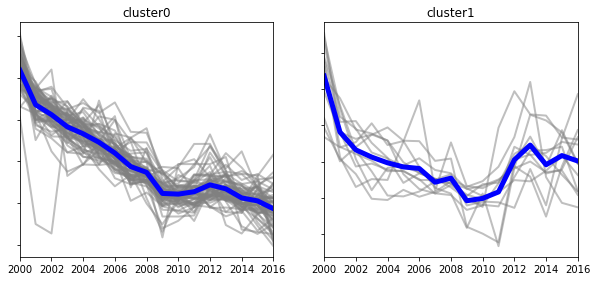

In [33]:
plotkmeans(2)

### Figure 4. The cluster centers (blue line) and all cluster members (grey line) for 2 k-means clusters of total crimes at the precinct level.

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


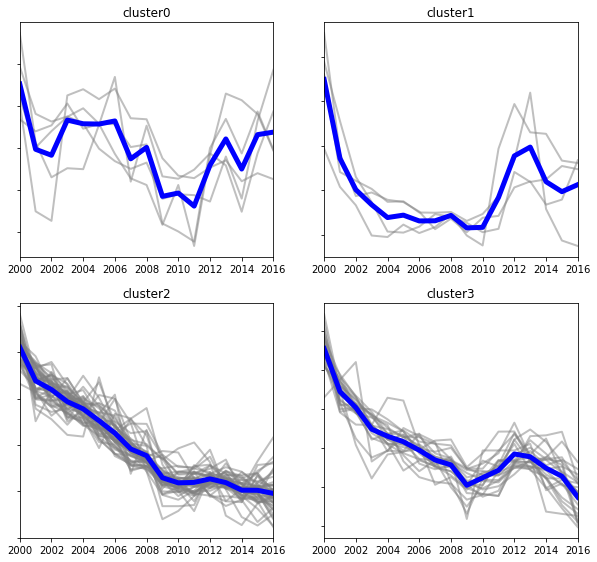

In [34]:
plotkmeans(4)

### Figure 5. The cluster centers (blue line) and all cluster members (grey line) for 4 k-means clusters of total crimes at the precinct level.

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


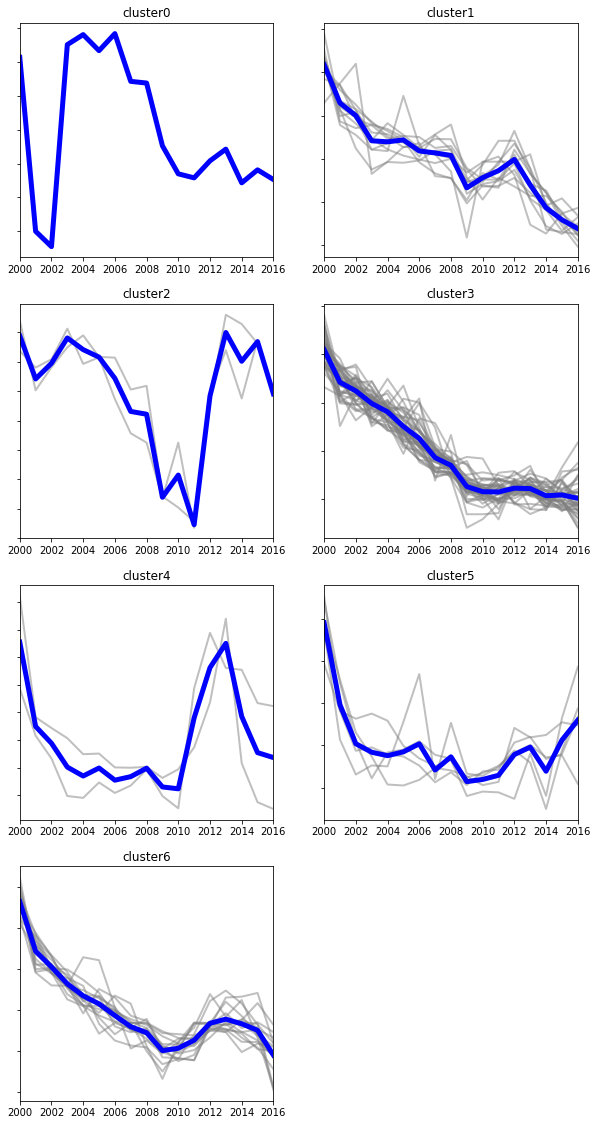

In [35]:
plotkmeans(7)

### Figure 6. The cluster centers (blue line) and all cluster members (grey line) for 7 k-means clusters of total crimes at the precinct level.

### Discussion: From the plots, I choose to use 4 clusters. 7 clusters seems too many since there are clusters with only one or a few time series. In the case of 4 clusters, for cluster 2 and cluster 3, the trend is downward, with the difference that in cluster 3, there was a slightly increase around 2012. Cluster 0 do not show a very clear trend which fluctuates over the years. In cluster 1, a quick decrease is observed at the begining, then from 2004, the trend was stable and then around 2013, there was a increase happened.

# Part 2: connecting the temporal and spatial components.
## 2.1 obtain the NYC precincts geometry and read it in as a shapefile           

In [36]:
urllib.urlretrieve('https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nypp_17d.zip', "precinct.gz")

('precinct.gz', <httplib.HTTPMessage instance at 0x7fc04b6a9f38>)

In [37]:
os.system("mv precinct.gz " + os.getenv("PUIDATA"))

0

In [38]:
os.system("unzip " + os.getenv("PUIDATA") + "/precinct.gz -d " + os.getenv("PUIDATA") + "/precinctshp" )

0

In [39]:
prshp = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/precinctshp/nypp_17d/nypp.shp")

In [40]:
prshp.head()

,Precinct,Shape_Leng,Shape_Area,geometry
0,1,80586.154615,4.730176e+07,(POLYGON ((972081.7882080078 190733.4674072266...
1,5,18676.124259,1.808880e+07,"POLYGON ((987399.2067871094 202660.9920043945,..."
2,6,27182.610113,2.213193e+07,"POLYGON ((984337.591796875 208351.1055908203, ..."
3,7,17301.308682,1.836402e+07,"POLYGON ((991608.6323852539 201215.2305908203,..."
4,9,19773.233410,2.139423e+07,"POLYGON ((992119.1235961914 204042.7609863281,..."


## 2.2 merge the precincts geodataframe with the dataframe of crime and plot a choropleth of the clusters. 

In [41]:
totcrime.head()

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,...,2010,2011,2012,2013,2014,2015,2016,Kmeans2,Kmeans4,Kmeans7
7,1,TOTAL SEVEN MAJOR FELONY OFFENSES,3438.0,3069.0,2715.0,2649.0,2383.0,2305.0,2013.0,1914.0,...,1445.0,1402.0,1416.0,1416.0,1208.0,1446.0,1395.0,0,2,3
15,5,TOTAL SEVEN MAJOR FELONY OFFENSES,1780.0,1458.0,1309.0,1231.0,1170.0,1131.0,1040.0,1031.0,...,969.0,962.0,1001.0,980.0,870.0,917.0,899.0,0,3,6
23,6,TOTAL SEVEN MAJOR FELONY OFFENSES,2387.0,2141.0,2059.0,2068.0,2174.0,2055.0,1979.0,1837.0,...,1530.0,1504.0,1574.0,1703.0,1575.0,1521.0,1388.0,0,2,3
31,7,TOTAL SEVEN MAJOR FELONY OFFENSES,990.0,892.0,908.0,864.0,857.0,804.0,864.0,856.0,...,702.0,704.0,762.0,711.0,732.0,781.0,823.0,0,2,3
39,9,TOTAL SEVEN MAJOR FELONY OFFENSES,2115.0,1672.0,1809.0,1801.0,1747.0,1664.0,1579.0,1519.0,...,1387.0,1350.0,1419.0,1424.0,1331.0,1337.0,1463.0,0,2,3


In [42]:
prshp.head()

,Precinct,Shape_Leng,Shape_Area,geometry
0,1,80586.154615,4.730176e+07,(POLYGON ((972081.7882080078 190733.4674072266...
1,5,18676.124259,1.808880e+07,"POLYGON ((987399.2067871094 202660.9920043945,..."
2,6,27182.610113,2.213193e+07,"POLYGON ((984337.591796875 208351.1055908203, ..."
3,7,17301.308682,1.836402e+07,"POLYGON ((991608.6323852539 201215.2305908203,..."
4,9,19773.233410,2.139423e+07,"POLYGON ((992119.1235961914 204042.7609863281,..."


In [43]:
prshp['Precinct'] = prshp['Precinct'].astype(int)

In [44]:
prshp1 = prshp.merge(totcrime,left_on='Precinct',right_on='PCT')

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


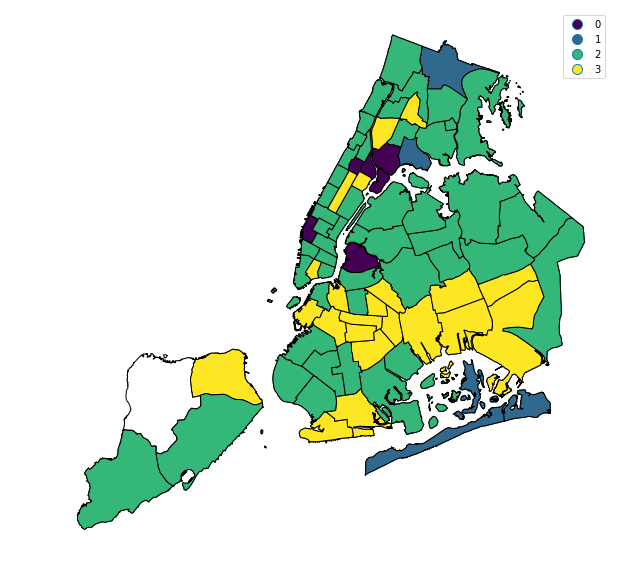

In [45]:
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(111)
prshp.plot(ax=ax1, color='white', linewidth=1, edgecolor='black',)
prshp1.plot(ax=ax1, column='Kmeans4', cmap='viridis', edgecolor='black', categorical = True, legend=True);
ax1.set_axis_off()
ax1.legend()

### Figure 7. Cloropleth of 4 k-means clusters of crime numbers at the precinct level with each color indicates a cluster. The plot shows that in most part of Manhattan, north of Queens, and middle of Brooklyn, there was a steady decrease of crime numbers (cluster 2). In the south of Brooklyn and Queens, Southeast point of Manhattan, the crime number decreased with a slight increase around 2012 (cluster 3). There is a white part in Staten Island which correspond to precinct 121 which is dropped for time series analysis because of lose of data before 2013.

### visualize each crime by precinct. 

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


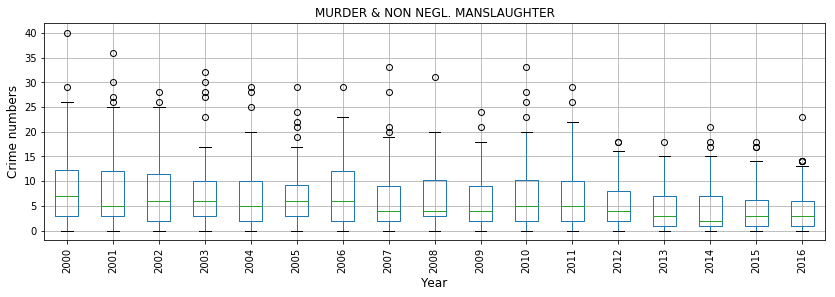

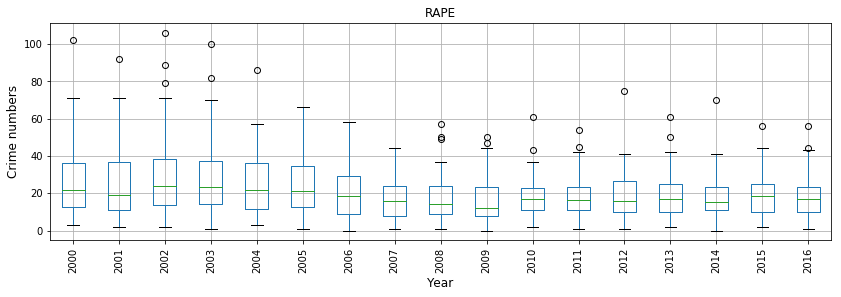

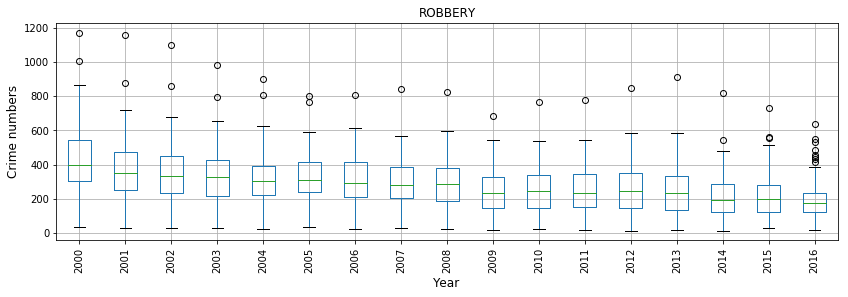

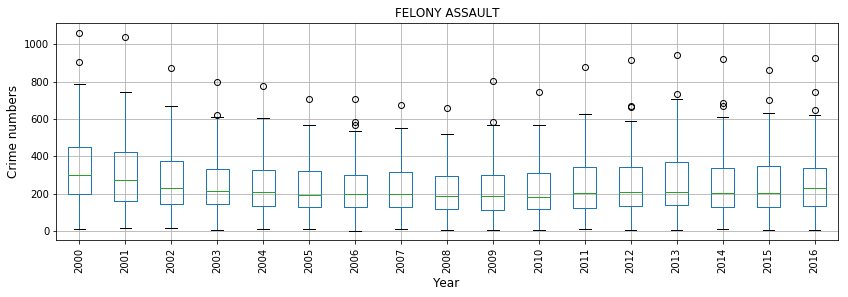

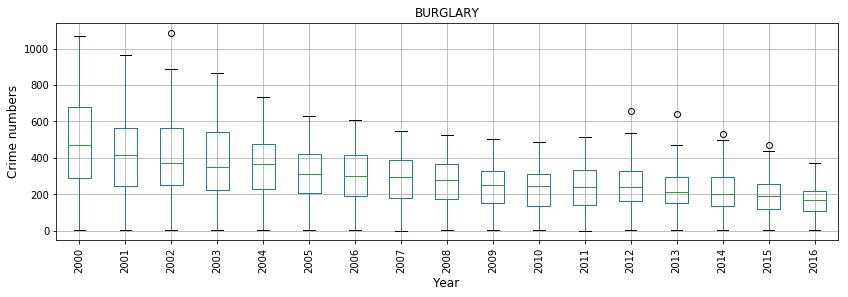

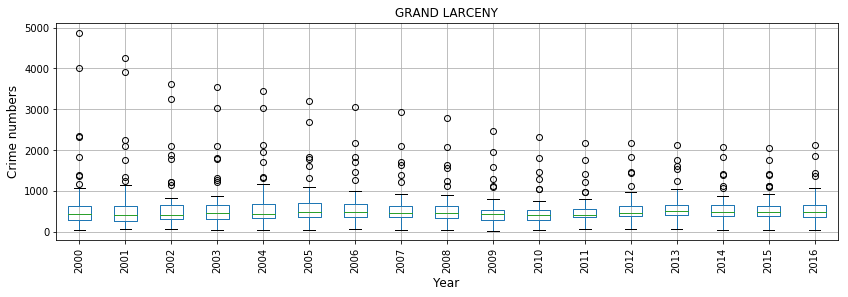

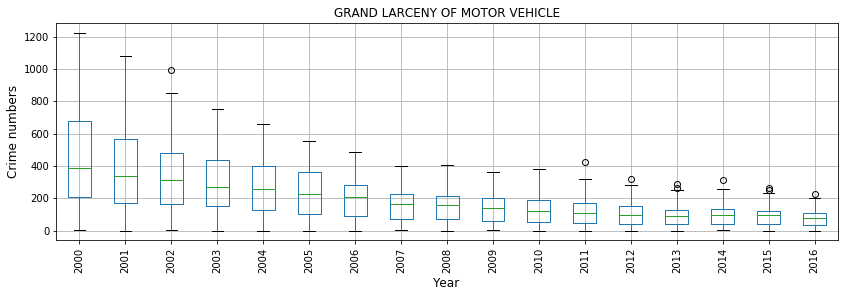

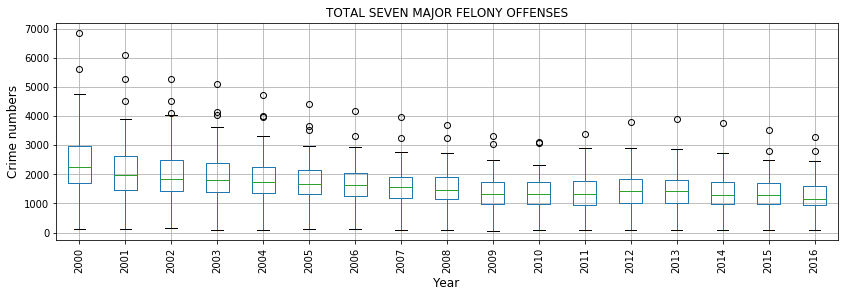

In [46]:
for i in range(8):
    group = crimet.iloc[:,range(i,608,8)]
    group.index = pd.to_datetime(group.index, format='%Y')
    group.index = group.index.strftime("%Y")
    group_t = group.T.astype('int64')

    f, ax = plt.subplots(figsize=(14,4))
    group_t.boxplot(figsize=(15,7), ax=ax, rot=90);
    plt.xlabel('Year', fontsize = 12)
    plt.ylabel('Crime numbers', fontsize = 12)
    plt.title(crimetype[i]) 
    plt.show()

### Figure 8. Box plots of the seven major felonies and for the total from 2000 to 2016 at the precinct level. The plots show that except for assault and larceny, most of the trend is downward.

## 2.3 download the data containing the socioeconomic features to be used as exogenous variables. 

In [47]:
SQL_SOURCE = 'https://fb55.carto.com:443/api/v2/sql?q='

import urllib2
import urllib
import StringIO
import ast

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    '''queries carto datasets from a given carto account
    designed for the carto API, tested only with CSV return format'''
    
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return response.read()

In [48]:
test = '''
SELECT precinct, green, medianincome, unemployment
FROM nycsocioeconomicsbyprecinct
'''

In [49]:
socioeconomics = pd.read_csv(StringIO.StringIO(queryCartoDB(test)), sep=',')

In [50]:
socioeconomics.head()

,precinct,green,medianincome,unemployment
0,1,0.058702,124092.068749,0.021444
1,60,0.173512,35015.008703,0.056448
2,61,0.238375,65998.923662,0.055458
3,63,0.158530,33655.205265,0.031215
4,24,0.166040,113966.467973,0.043461


## 2.4 pivot the crime dataframe so that you have a dataframe with precinct on the index and each crime type on the columns 

In [51]:
df1.head()

,PCT,CRIME,mean,std
0,1,MURDER & NON NEGL. MANSLAUGHTER ...,1.058824,0.966345
1,1,RAPE,8.588235,3.063063
2,1,ROBBERY,125.705882,56.514118
3,1,FELONY ASSAULT,104.882353,28.676825
4,1,BURGLARY,242.176471,107.459431


In [52]:
crimepivot = df1.pivot('PCT', 'CRIME')['mean']

In [53]:
crimepivot.head()

CRIME,BURGLARY,FELONY ASSAULT,GRAND LARCENY,GRAND LARCENY OF MOTOR VEHICLE,MURDER & NON NEGL. MANSLAUGHTER,RAPE,ROBBERY,TOTAL SEVEN MAJOR FELONY OFFENSES
PCT,,,,,,,,
1,242.176471,104.882353,1406.705882,81.470588,1.058824,8.588235,125.705882,1970.588235
5,152.941176,130.941176,616.823529,45.882353,1.882353,7.529412,147.058824,1103.058824
6,225.588235,114.352941,1183.000000,82.117647,1.294118,9.470588,199.823529,1815.647059
7,108.176471,124.411765,317.352941,74.117647,2.588235,10.705882,172.000000,809.352941
9,247.882353,169.647059,833.176471,89.529412,2.294118,15.470588,208.764706,1566.764706


## 2.5 merge the dataframe with the socioeconomic data with the pivoted crime data,  and merge the precinct geodataframe with it. plot a choropleth of each of the 7 felonies, plus the total crime by precinct
clean up your data so that the only columns left are the 7 felonies, the total number of felonies, and the socioeconomic features (unemployment, median income, park access). I recommend you rename the crime features: the dataframes have very annoying white spaces encoded in them. See the hints file to remove them.

In [54]:
crimepivot.head()

CRIME,BURGLARY,FELONY ASSAULT,GRAND LARCENY,GRAND LARCENY OF MOTOR VEHICLE,MURDER & NON NEGL. MANSLAUGHTER,RAPE,ROBBERY,TOTAL SEVEN MAJOR FELONY OFFENSES
PCT,,,,,,,,
1,242.176471,104.882353,1406.705882,81.470588,1.058824,8.588235,125.705882,1970.588235
5,152.941176,130.941176,616.823529,45.882353,1.882353,7.529412,147.058824,1103.058824
6,225.588235,114.352941,1183.000000,82.117647,1.294118,9.470588,199.823529,1815.647059
7,108.176471,124.411765,317.352941,74.117647,2.588235,10.705882,172.000000,809.352941
9,247.882353,169.647059,833.176471,89.529412,2.294118,15.470588,208.764706,1566.764706


In [55]:
socioeconomics.head()

,precinct,green,medianincome,unemployment
0,1,0.058702,124092.068749,0.021444
1,60,0.173512,35015.008703,0.056448
2,61,0.238375,65998.923662,0.055458
3,63,0.158530,33655.205265,0.031215
4,24,0.166040,113966.467973,0.043461


In [56]:
df2 = pd.merge(crimepivot, socioeconomics, how='inner', right_on="precinct", left_index=True)

In [57]:
df2.head()

CRIME,BURGLARY,FELONY ASSAULT,GRAND LARCENY,GRAND LARCENY OF MOTOR VEHICLE,MURDER & NON NEGL. MANSLAUGHTER,RAPE,ROBBERY,TOTAL SEVEN MAJOR FELONY OFFENSES,precinct,green,medianincome,unemployment
0,242.176471,104.882353,1406.705882,81.470588,1.058824,8.588235,125.705882,1970.588235,1,0.058702,124092.068749,0.021444
30,152.941176,130.941176,616.823529,45.882353,1.882353,7.529412,147.058824,1103.058824,5,0.049462,99148.860914,0.046260
35,225.588235,114.352941,1183.000000,82.117647,1.294118,9.470588,199.823529,1815.647059,6,0.035655,119565.099444,0.029992
36,108.176471,124.411765,317.352941,74.117647,2.588235,10.705882,172.000000,809.352941,7,0.125848,44645.989878,0.052540
14,247.882353,169.647059,833.176471,89.529412,2.294118,15.470588,208.764706,1566.764706,9,0.080894,82391.812180,0.041264


In [58]:
df2.columns

Index([                          u'BURGLARY                              ',
                                 u'FELONY ASSAULT                        ',
                                 u'GRAND LARCENY                         ',
       u'GRAND LARCENY OF MOTOR VEHICLE                                  ',
        u'MURDER & NON NEGL. MANSLAUGHTER                                ',
                                 u'RAPE                                  ',
                                 u'ROBBERY                               ',
                                      u'TOTAL SEVEN MAJOR FELONY OFFENSES',
                                                               u'precinct',
                                                                  u'green',
                                                           u'medianincome',
                                                           u'unemployment'],
      dtype='object', name=u'CRIME')

In [59]:
df2.rename(columns = { u'BURGLARY                              ': 'BURGLARY',\
                           u'FELONY ASSAULT                        ': 'FELONY ASSAULT',\
                           u'GRAND LARCENY                         ': 'GRAND LARCENY',\
                           u'GRAND LARCENY OF MOTOR VEHICLE                                  ': 'GRAND LARCENY OF MOTOR VEHICLE',\
                           u'MURDER & NON NEGL. MANSLAUGHTER                                ': 'MURDER & NON NEGL. MANSLAUGHTER',\
                           u'RAPE                                  ': 'RAPE',\
                           u'ROBBERY                               ': 'ROBBERY'}, inplace=True)

In [60]:
df2.set_index('precinct',inplace=True)

In [61]:
df2.head()

CRIME,BURGLARY,FELONY ASSAULT,GRAND LARCENY,GRAND LARCENY OF MOTOR VEHICLE,MURDER & NON NEGL. MANSLAUGHTER,RAPE,ROBBERY,TOTAL SEVEN MAJOR FELONY OFFENSES,green,medianincome,unemployment
precinct,,,,,,,,,,,
1,242.176471,104.882353,1406.705882,81.470588,1.058824,8.588235,125.705882,1970.588235,0.058702,124092.068749,0.021444
5,152.941176,130.941176,616.823529,45.882353,1.882353,7.529412,147.058824,1103.058824,0.049462,99148.860914,0.046260
6,225.588235,114.352941,1183.000000,82.117647,1.294118,9.470588,199.823529,1815.647059,0.035655,119565.099444,0.029992
7,108.176471,124.411765,317.352941,74.117647,2.588235,10.705882,172.000000,809.352941,0.125848,44645.989878,0.052540
9,247.882353,169.647059,833.176471,89.529412,2.294118,15.470588,208.764706,1566.764706,0.080894,82391.812180,0.041264


In [62]:
# merge the precinct geodataframe
prshp2 = prshp.merge(df2, left_on='Precinct', right_index=True)

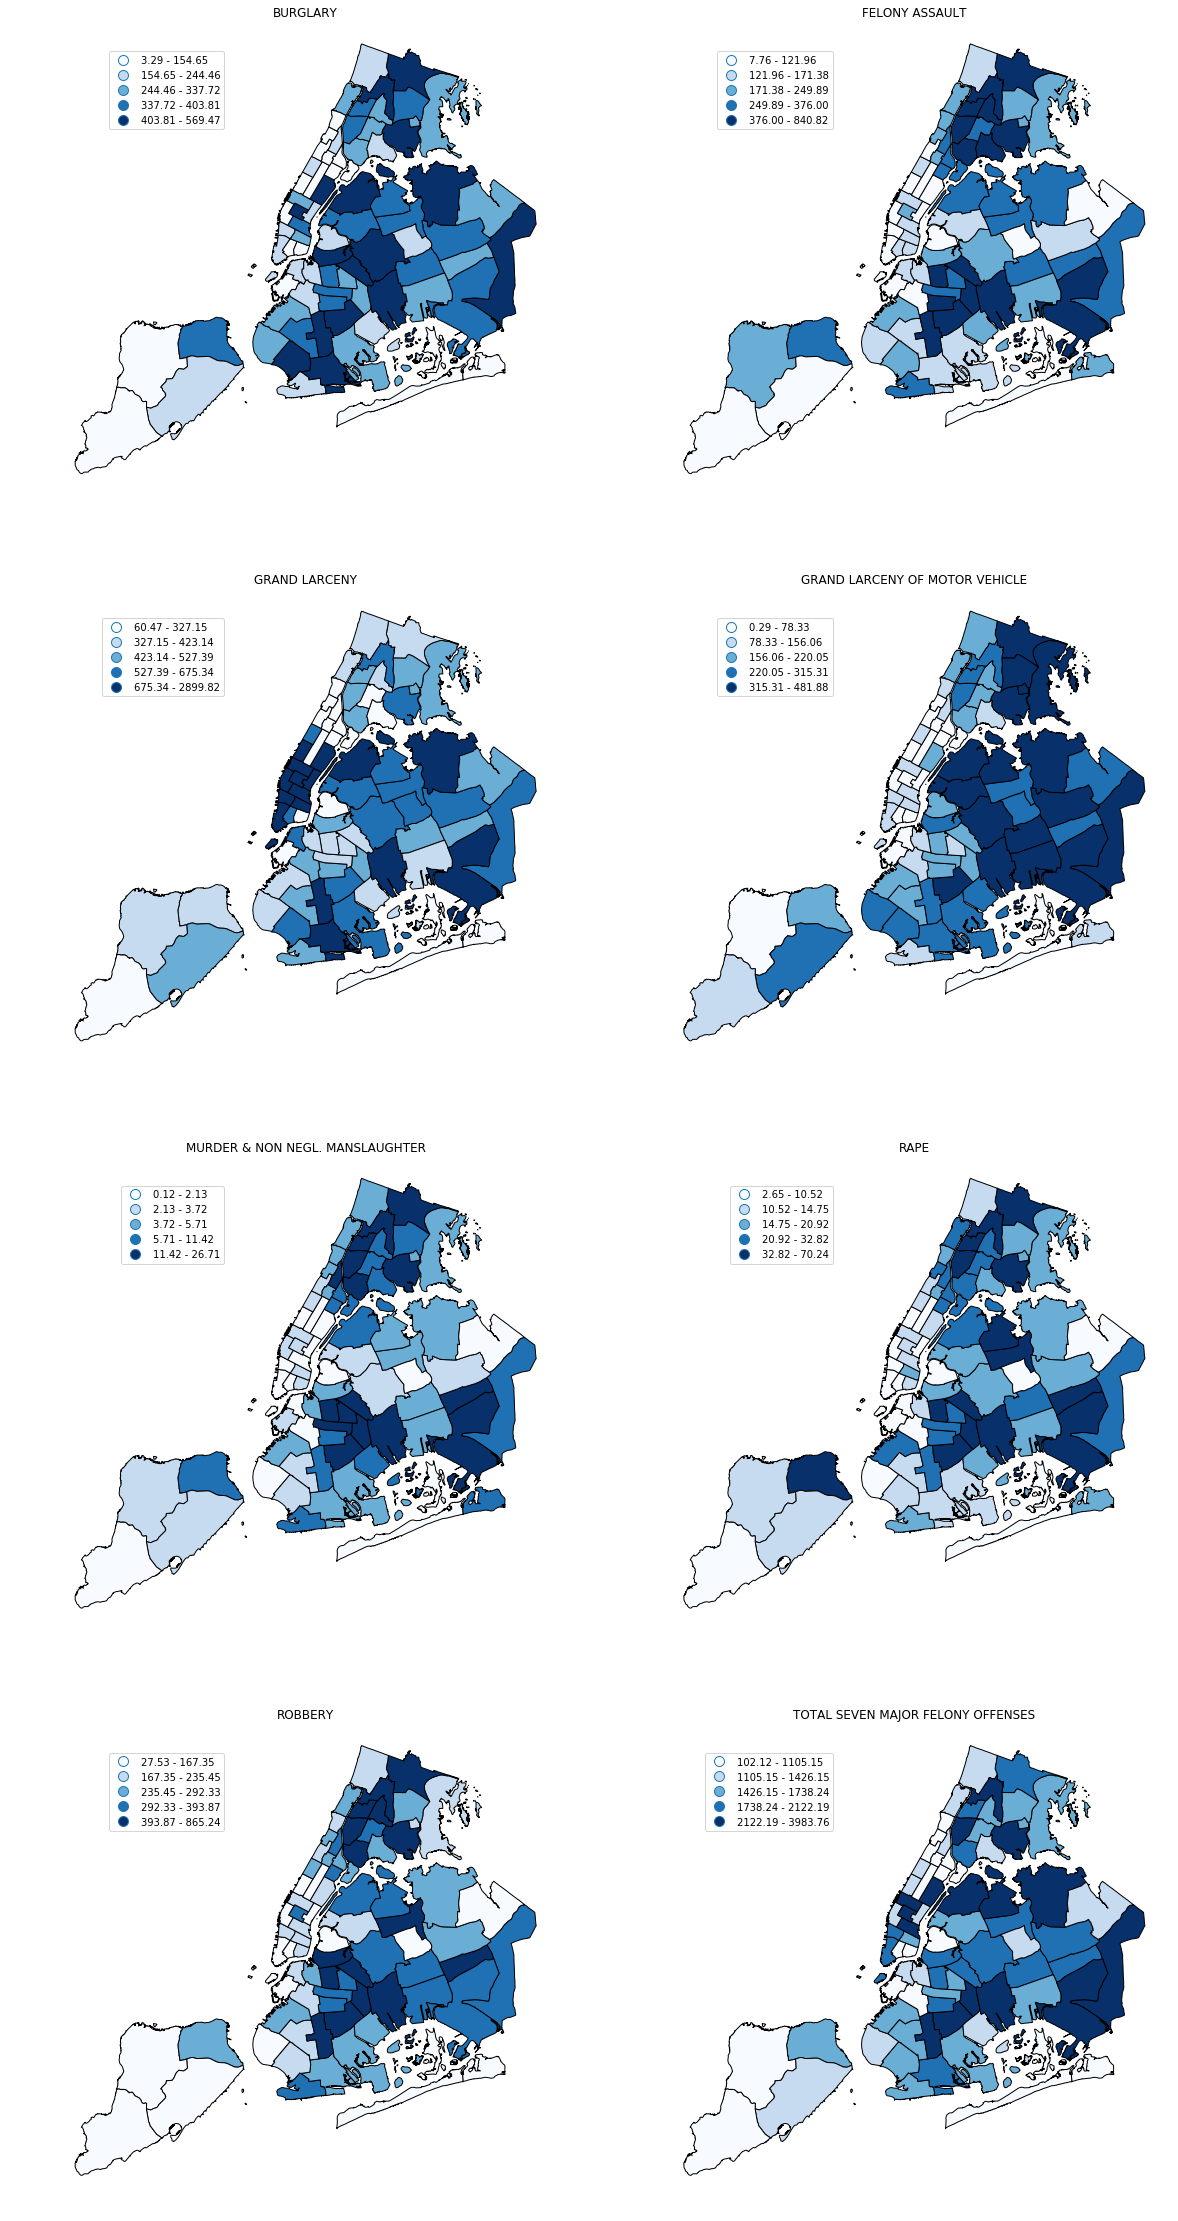

In [63]:
fig = plt.figure(figsize = (20,40))
ax1 = fig.add_subplot(421)
#prshp2.plot(ax=ax1, color='black', linewidth=1, alpha=0.1)
prshp2.plot(ax=ax1, column='BURGLARY', cmap='Blues', edgecolor='black', scheme='quantiles', k=5, legend=True);
ax1.set_axis_off()
ax1.set_title('BURGLARY', size=12)
legend1 = ax1.get_legend()
legend1.set_bbox_to_anchor((0.15, 0.75, 0.2, 0.2))


ax2 = fig.add_subplot(422)
prshp2.plot(ax=ax2, column='FELONY ASSAULT', cmap='Blues', edgecolor='black', scheme='quantiles', k=5, legend=True);
ax2.set_axis_off()
ax2.set_title('FELONY ASSAULT', size=12)
legend1 = ax2.get_legend()
legend1.set_bbox_to_anchor((0.15, 0.75, 0.2, 0.2))

ax3 = fig.add_subplot(423)
prshp2.plot(ax=ax3, column='GRAND LARCENY', cmap='Blues', edgecolor='black', scheme='quantiles', k=5, legend=True);
ax3.set_axis_off()
ax3.set_title('GRAND LARCENY', size=12)
legend1 = ax3.get_legend()
legend1.set_bbox_to_anchor((0.15, 0.75, 0.2, 0.2))


ax4 = fig.add_subplot(424)
prshp2.plot(ax=ax4, column='GRAND LARCENY OF MOTOR VEHICLE', cmap='Blues', edgecolor='black', scheme='quantiles', k=5, legend=True);
ax4.set_axis_off()
ax4.set_title('GRAND LARCENY OF MOTOR VEHICLE', size=12)
legend1 = ax4.get_legend()
legend1.set_bbox_to_anchor((0.15, 0.75, 0.2, 0.2))


ax5 = fig.add_subplot(425)
prshp2.plot(ax=ax5, column='MURDER & NON NEGL. MANSLAUGHTER', cmap='Blues', edgecolor='black', scheme='quantiles', k=5, legend=True);
ax5.set_axis_off()
ax5.set_title('MURDER & NON NEGL. MANSLAUGHTER', size=12)
legend1 = ax5.get_legend()
legend1.set_bbox_to_anchor((0.15, 0.75, 0.2, 0.2))


ax6 = fig.add_subplot(426)
prshp2.plot(ax=ax6, column='RAPE', cmap='Blues', edgecolor='black', scheme='quantiles', k=5, legend=True);
ax6.set_axis_off()
ax6.set_title('RAPE', size=12)
legend1 = ax6.get_legend()
legend1.set_bbox_to_anchor((0.15, 0.75, 0.2, 0.2))


ax7 = fig.add_subplot(427)
prshp2.plot(ax=ax7, column='ROBBERY', cmap='Blues', edgecolor='black', scheme='quantiles', k=5, legend=True);
ax7.set_axis_off()
ax7.set_title('ROBBERY', size=12)
legend1 = ax7.get_legend()
legend1.set_bbox_to_anchor((0.15, 0.75, 0.2, 0.2))


ax8 = fig.add_subplot(428)
prshp2.plot(ax=ax8, column='TOTAL SEVEN MAJOR FELONY OFFENSES', cmap='Blues', edgecolor='black', scheme='quantiles', k=5, legend=True);
ax8.set_axis_off()
ax8.set_title('TOTAL SEVEN MAJOR FELONY OFFENSES', size=12)
legend1 = ax8.get_legend()
legend1.set_bbox_to_anchor((0.15, 0.75, 0.2, 0.2))

### Figure 9. Choropleth of each of the 7 felonies, plus the total crime by precinct. For different crime types, the pattern is different. The crime number in Manhattan is not very high except for larceny. Generally speaking, the Bronx and south of Queens have higher crime numbers.

## 2.6 cluster the data first using the socioeconomic features and then using the 7 felonies 
You can use a simple Euclidean distance, since these are all numerical features, which is the default for most packages, or define your distance. if you do that, which would be exciting, please justify your distance definition. Mind the preprocessing! Do the clusters make sense?, is the grouping preserved? are the outliers outliers in both clustering schemes?

In [64]:
df2.head()

CRIME,BURGLARY,FELONY ASSAULT,GRAND LARCENY,GRAND LARCENY OF MOTOR VEHICLE,MURDER & NON NEGL. MANSLAUGHTER,RAPE,ROBBERY,TOTAL SEVEN MAJOR FELONY OFFENSES,green,medianincome,unemployment
precinct,,,,,,,,,,,
1,242.176471,104.882353,1406.705882,81.470588,1.058824,8.588235,125.705882,1970.588235,0.058702,124092.068749,0.021444
5,152.941176,130.941176,616.823529,45.882353,1.882353,7.529412,147.058824,1103.058824,0.049462,99148.860914,0.046260
6,225.588235,114.352941,1183.000000,82.117647,1.294118,9.470588,199.823529,1815.647059,0.035655,119565.099444,0.029992
7,108.176471,124.411765,317.352941,74.117647,2.588235,10.705882,172.000000,809.352941,0.125848,44645.989878,0.052540
9,247.882353,169.647059,833.176471,89.529412,2.294118,15.470588,208.764706,1566.764706,0.080894,82391.812180,0.041264


### Cluster the data using the socioeconomic features.

In [65]:
df_s = df2[["green", "medianincome", "unemployment"]]
df_s.head()

CRIME,green,medianincome,unemployment
precinct,,,
1,0.058702,124092.068749,0.021444
5,0.049462,99148.860914,0.046260
6,0.035655,119565.099444,0.029992
7,0.125848,44645.989878,0.052540
9,0.080894,82391.812180,0.041264


In [66]:
# preprocess the data
Xscaled_s = preprocessing.scale(df_s)

In [67]:
# preprocessed by stadndardizing by column
Xscaled_s.std(axis=0), Xscaled_s.std(axis=1)

(array([ 1.,  1.,  1.]),
 array([ 1.25269187,  0.71457955,  1.13506487,  0.20855486,  0.49861156,
         1.11755112,  1.06181978,  1.3001124 ,  1.12905953,  0.97686649,
         1.44122925,  1.2307199 ,  3.68581929,  0.4888171 ,  0.80896773,
         1.05871737,  0.80604225,  0.76572513,  0.10680334,  0.837612  ,
         0.43371498,  0.82670836,  0.98864445,  0.80215336,  1.01714216,
         0.69267006,  0.82676851,  1.16082567,  0.96159162,  0.62274402,
         1.08917927,  0.46884848,  1.05247973,  1.03288241,  0.45942557,
         0.43339713,  0.26823026,  0.53962861,  0.14356173,  0.58382   ,
         0.31484298,  0.45089514,  0.26492669,  0.67670352,  0.14639665,
         0.89176152,  0.69225606,  0.64193041,  0.36615698,  1.07139245,
         0.58646384,  0.77026478,  0.73098064,  1.1166423 ,  0.55771455,
         0.32658159,  0.42511015,  0.34633268,  0.59714814,  0.39034834,
         0.99458692,  0.47624694,  0.11734767,  0.30586524,  0.21959487,
         0.27699023,  0.24

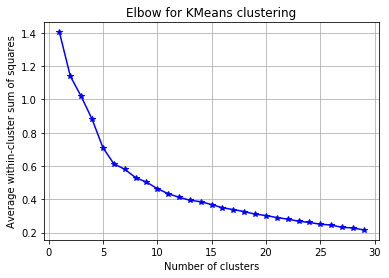

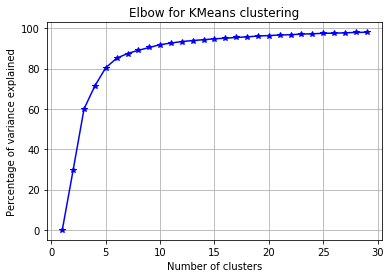

In [68]:
elbow(Xscaled_s, range(1,30))

### Figure 10. Elbow for KMeans clustering. From the plot, I chose 5 clusters where squared error (SSE) decreases abruptly.

### Use PCA to visualize the data in two dimensions. 

In [69]:
# Use PCA
pca = PCA(0.95)
Xproj = pca.fit_transform(Xscaled_s)
eigenvalues = pca.explained_variance_
print (pca.explained_variance_ratio_)

[ 0.60745196  0.25212432  0.14042372]


In [70]:
# Kmeans the number of clusters = 5
Nc = 5
km = cluster.KMeans(n_clusters=Nc, random_state=123)
km.fit(Xscaled_s)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=123, tol=0.0001, verbose=0)

In [71]:
km.labels_

array([2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 4, 1, 2, 0, 0, 2, 1, 3, 0, 0, 3,
       3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 3, 1, 3, 1, 3, 1, 3,
       3, 2, 1, 0, 3, 3, 3, 2, 1, 1, 1, 1, 0, 1, 3, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 3, 1, 1, 1, 1, 1, 1], dtype=int32)

In [72]:
km.cluster_centers_

array([[ 1.30701332, -0.36839593, -0.03566582],
       [-0.24933366,  0.05826812, -0.37710191],
       [-0.43282481,  1.64474179, -0.63250128],
       [-0.41830102, -0.93740652,  0.71954977],
       [ 6.22141769, -1.60554689,  6.20506979]])

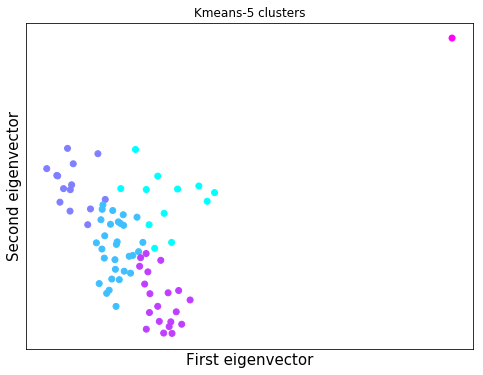

In [73]:
#Plot
plt.figure(figsize=(8,6))
plt.scatter(Xproj[:, 0], Xproj[:, 1], c=km.labels_, cmap=plt.cm.cool)
plt.xlabel('First eigenvector', fontsize = 15)
plt.ylabel('Second eigenvector', fontsize = 15)
plt.xticks(())
plt.yticks(())
plt.title("Kmeans-{} clusters".format(Nc))
plt.show()

### Figure 11. The clusters of socioeconomic features after PCA. There is an outlier in the top right of the plot, but itself is a cluster and will not affect other clusters. From the later analysis, we identify it is Central Park.

In [74]:
df_s['clusters'] = km.labels_
df_s.head()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


CRIME,green,medianincome,unemployment,clusters
precinct,,,,
1,0.058702,124092.068749,0.021444,2
5,0.049462,99148.860914,0.046260,2
6,0.035655,119565.099444,0.029992,2
7,0.125848,44645.989878,0.052540,1
9,0.080894,82391.812180,0.041264,1


In [75]:
prshp3 = prshp.merge(df_s, left_on='Precinct', right_index=True)

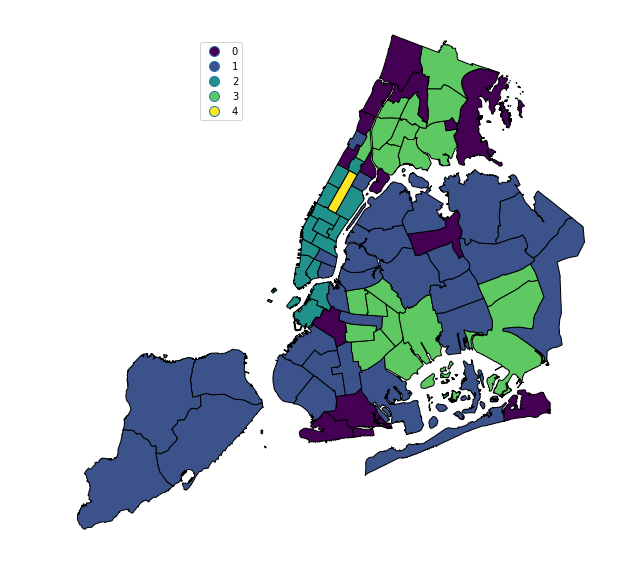

In [76]:
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(111)
prshp3.plot(ax=ax1, column='clusters', cmap='viridis', edgecolor='black', categorical = True, legend=True);
ax1.set_axis_off()
legend1 = ax1.get_legend()
legend1.set_bbox_to_anchor((0.15, 0.75, 0.2, 0.2))

### Figure 12. Cloropleth of 5 k-means clusters of socioeconomic features at the precinct level with each color indicates a cluster. The cluster is reasonable. The plot shows that cluster 2 which include middle and southwest part of Manhattan and downtown Brooklyn represent higher income and lower unemployment rate. Cluster 3 includes the Bronx and south of Queens where have lower income and higher unemployment rate. The central part itself is a cluster which seems like an outlier. By further examination, I found that central park has an extream high green area, low income, and high unemployment rate.

### Central park itself is a cluster with very different socioeconomic features compare to the rest of the city. The outlier is dropped in the model part.

In [77]:
df_s[df_s['clusters'] == 4]

CRIME,green,medianincome,unemployment,clusters
precinct,,,,
22,0.953881,5.015011,0.249993,4


### Cluster the data first using the 7 felonies

In [78]:
df_f = df2.iloc[:,0:7]
df_f.head()

CRIME,BURGLARY,FELONY ASSAULT,GRAND LARCENY,GRAND LARCENY OF MOTOR VEHICLE,MURDER & NON NEGL. MANSLAUGHTER,RAPE,ROBBERY
precinct,,,,,,,
1,242.176471,104.882353,1406.705882,81.470588,1.058824,8.588235,125.705882
5,152.941176,130.941176,616.823529,45.882353,1.882353,7.529412,147.058824
6,225.588235,114.352941,1183.000000,82.117647,1.294118,9.470588,199.823529
7,108.176471,124.411765,317.352941,74.117647,2.588235,10.705882,172.000000
9,247.882353,169.647059,833.176471,89.529412,2.294118,15.470588,208.764706


In [79]:
Xscaled_f = preprocessing.scale(df_f)

In [80]:
# preprocessed by stadndardizing by column
Xscaled_f.std(axis=0), Xscaled_f.std(axis=1)

(array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.]),
 array([ 0.98284562,  0.40457553,  0.77041145,  0.24854275,  0.43979105,
         0.45079642,  1.0501608 ,  2.06342246,  0.6761084 ,  1.64312764,
         1.1628819 ,  0.55433557,  0.33173318,  0.60820074,  0.3085548 ,
         0.54635105,  0.31571952,  0.42259898,  0.48821684,  0.80633021,
         0.3617894 ,  0.21300831,  0.78631189,  0.58313712,  0.59360175,
         0.61169988,  0.84452185,  0.56213379,  0.77938504,  0.73514379,
         0.48031403,  0.47988035,  0.28467409,  0.57430523,  0.28204614,
         0.62660363,  0.52540444,  0.34975178,  0.46249117,  0.67027864,
         0.48694519,  0.25902209,  0.48484766,  0.35068773,  0.18964448,
         1.06085882,  1.21055628,  0.1705883 ,  0.5831142 ,  0.26708423,
         0.73087745,  0.58933766,  0.66401415,  0.41752283,  0.25288182,
         0.46168743,  0.31420927,  0.2516197 ,  0.42877537,  0.67048177,
         0.45177734,  0.8826487 ,  0.73084799,  0.6030078 ,  0.70944214,
      

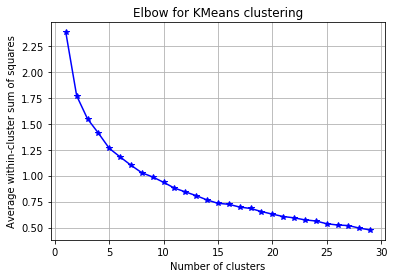

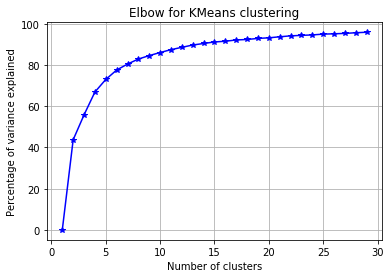

In [81]:
elbow(Xscaled_f, range(1,30))

### Figure 13. Elbow for KMeans clustering. From the plot, I chose 5 clusters.

### Use PCA to visualize the data in two dimensions.

In [82]:
# Use PCA
pca = PCA(0.95)
Xproj = pca.fit_transform(Xscaled_f)
eigenvalues = pca.explained_variance_
print (pca.explained_variance_ratio_)

[ 0.64959223  0.19003083  0.11729699]


In [83]:
# K-Means clustering: the essential parameter is the number of clusters.
Nc = 5
km = cluster.KMeans(n_clusters=Nc, random_state=123)
km.fit(Xscaled_f)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=123, tol=0.0001, verbose=0)

In [84]:
km.labels_

array([0, 4, 4, 4, 4, 4, 0, 0, 4, 0, 0, 4, 4, 2, 4, 2, 4, 4, 2, 2, 4, 2, 1,
       2, 2, 1, 1, 3, 1, 1, 2, 3, 4, 1, 2, 3, 3, 4, 3, 1, 4, 2, 1, 2, 2, 1,
       1, 4, 2, 4, 1, 2, 1, 4, 4, 3, 4, 4, 4, 3, 1, 3, 3, 3, 3, 3, 3, 3, 4,
       4, 1, 3, 3, 2, 4, 4, 4], dtype=int32)

In [85]:
km.cluster_centers_

array([[ 0.53866091, -0.62688249,  3.18812948, -0.84314315, -0.84824081,
        -0.69972556, -0.49689779],
       [ 0.91549492,  1.62468821, -0.06812307,  0.76188868,  1.65561219,
         1.52611486,  1.57902807],
       [-0.32504083,  0.3944089 , -0.51115347, -0.3940224 ,  0.39411722,
         0.34703014,  0.20355538],
       [ 0.90121097, -0.20179509, -0.01614761,  1.17738367, -0.30795011,
         0.01236118,  0.09663534],
       [-0.9279258 , -0.82587535, -0.26152817, -0.71772328, -0.737849  ,
        -0.86185967, -0.8970889 ]])

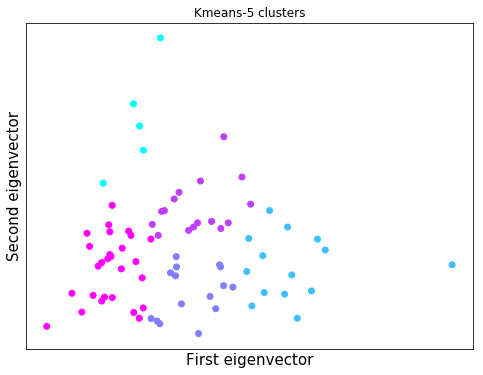

In [86]:
#Plot
plt.figure(figsize=(8,6))
plt.scatter(Xproj[:, 0], Xproj[:, 1], c=km.labels_, cmap=plt.cm.cool)
plt.xlabel('First eigenvector', fontsize = 15)
plt.ylabel('Second eigenvector', fontsize = 15)
plt.xticks(())
plt.yticks(())
plt.title("Kmeans-{} clusters".format(Nc))
plt.show()

### Figure 14. The clusters of 7 felonies after PCA.  The outlier is not that obvious comparing to the clusters of socioeconomic features.

In [87]:
df_f['clusters'] = km.labels_
df_f.head()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


CRIME,BURGLARY,FELONY ASSAULT,GRAND LARCENY,GRAND LARCENY OF MOTOR VEHICLE,MURDER & NON NEGL. MANSLAUGHTER,RAPE,ROBBERY,clusters
precinct,,,,,,,,
1,242.176471,104.882353,1406.705882,81.470588,1.058824,8.588235,125.705882,0
5,152.941176,130.941176,616.823529,45.882353,1.882353,7.529412,147.058824,4
6,225.588235,114.352941,1183.000000,82.117647,1.294118,9.470588,199.823529,4
7,108.176471,124.411765,317.352941,74.117647,2.588235,10.705882,172.000000,4
9,247.882353,169.647059,833.176471,89.529412,2.294118,15.470588,208.764706,4


In [88]:
prshp4 = prshp.merge(df_f, left_on='Precinct', right_index=True)

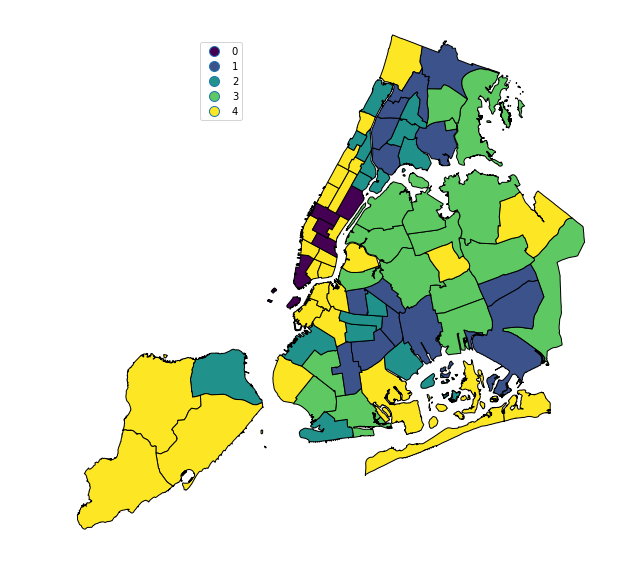

In [89]:
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(111)
prshp4.plot(ax=ax1, column='clusters', cmap='viridis', edgecolor='black', categorical = True, legend=True);
ax1.set_axis_off()
legend1 = ax1.get_legend()
legend1.set_bbox_to_anchor((0.15, 0.75, 0.2, 0.2))

### Figure 15. Cloropleth of 5 k-means clusters of 7 felonies at the precinct level with each color indicates a cluster. Overall the clusters are reasonable, cluster 1 include the Bronx and south of Queens which coincide with the socioeconomic clustering of low income and high unemployment rate, which shows the inner correlation of socioeconomic features and crimes. Middlewest of Manhattan and Downtown Brooklyn are also in one cluster where have similar socioeconomic features. As found in Figure 9,  different crime types have different patterns in space. But we do identify Bronx and south of Queens where coincide with highest crime rate areas in Figure 9. Central Park itself is not a cluster anymore which means that considering the number of 7 felonies, this area is not that different compared to the other part of the city.

## 2.7 At last, create a function that for a target variable input generates a model based on median income (medianincome), green area (green), and unemployed fraction (unemployment), and returns some parameter of model quality and the most important feature in the model. The function should also print or otherwise report whether the feature is statistically significant. Run this function four times to predict BURGLARY, RAPE, MURDER, and TOTAL CRIME

I want this to be a function:

        def fitCrime(...):
            ...
            return importance,quality
    
You can run the function with all the precincts, or with the clusters you created above, but discuss the pros and cons of each scheme. You can use any model. I am ok with multi linear regression, but consider other options: trees, SVM, whatever you have explored in PUI, in other classes, in the EC project. I am not looking for a rigorous assessment. If you use statsmodels for regression you can pull any of the diagnostics in the model.summary() (any of the *appropriate* ones). If you use a machine learning method you can assess via cross validation, seeing how much the score changes between test and training sample. Keep in mind that am definitely more interested in the discussion than in the creation of a "good" model. 

**Discuss explicitly which features are important to predict what** 

In [90]:
df2.head()

CRIME,BURGLARY,FELONY ASSAULT,GRAND LARCENY,GRAND LARCENY OF MOTOR VEHICLE,MURDER & NON NEGL. MANSLAUGHTER,RAPE,ROBBERY,TOTAL SEVEN MAJOR FELONY OFFENSES,green,medianincome,unemployment
precinct,,,,,,,,,,,
1,242.176471,104.882353,1406.705882,81.470588,1.058824,8.588235,125.705882,1970.588235,0.058702,124092.068749,0.021444
5,152.941176,130.941176,616.823529,45.882353,1.882353,7.529412,147.058824,1103.058824,0.049462,99148.860914,0.046260
6,225.588235,114.352941,1183.000000,82.117647,1.294118,9.470588,199.823529,1815.647059,0.035655,119565.099444,0.029992
7,108.176471,124.411765,317.352941,74.117647,2.588235,10.705882,172.000000,809.352941,0.125848,44645.989878,0.052540
9,247.882353,169.647059,833.176471,89.529412,2.294118,15.470588,208.764706,1566.764706,0.080894,82391.812180,0.041264


In [91]:
df2.columns = ([                u'BURGLARY',
                          u'FELONY_ASSAULT',
                           u'GRAND_LARCENY',
          u'GRAND_LARCENY_OF_MOTOR_VEHICLE',
            u'MURDER_NON_NEGL_MANSLAUGHTER',
                                    u'RAPE',
                                 u'ROBBERY',
       u'TOTAL_SEVEN_MAJOR_FELONY_OFFENSES',
                                   u'green',
                            u'medianincome',
                            u'unemployment'])

### Take out outlier for the model, the number of observation is not large, only drop oberservations that fall outside the threshold of three standard deviations.

In [92]:
def clean(feature):   
    index = ((feature < np.mean(feature) + 3 * np.std(feature)) & (feature > np.mean(feature)- 3 * np.std(feature)))
    return index

In [93]:
df3 = df2[clean(df2.BURGLARY) & clean(df2.FELONY_ASSAULT) & clean(df2.GRAND_LARCENY) & clean(df2.GRAND_LARCENY_OF_MOTOR_VEHICLE) \
    & clean(df2.MURDER_NON_NEGL_MANSLAUGHTER) & clean(df2.RAPE) & clean(df2.ROBBERY) & clean(df2.TOTAL_SEVEN_MAJOR_FELONY_OFFENSES) \
    & clean(df2.green) & clean(df2.medianincome) & clean(df2.unemployment)]
df3.reset_index(inplace=True, drop=True) 

In [94]:
df3.shape

(73, 11)

### Preprocesse the dataset.

In [95]:
XY = preprocessing.scale(df3)
df4 = pd.DataFrame(XY)

In [96]:
df4.columns = ([                u'BURGLARY',
                          u'FELONY_ASSAULT',
                           u'GRAND_LARCENY',
          u'GRAND_LARCENY_OF_MOTOR_VEHICLE',
            u'MURDER_NON_NEGL_MANSLAUGHTER',
                                    u'RAPE',
                                 u'ROBBERY',
       u'TOTAL_SEVEN_MAJOR_FELONY_OFFENSES',
                                   u'green',
                            u'medianincome',
                            u'unemployment'])

In [97]:
df4.head()

,BURGLARY,FELONY_ASSAULT,GRAND_LARCENY,GRAND_LARCENY_OF_MOTOR_VEHICLE,MURDER_NON_NEGL_MANSLAUGHTER,RAPE,ROBBERY,TOTAL_SEVEN_MAJOR_FELONY_OFFENSES,green,medianincome,unemployment
0,-0.410794,-1.012905,3.017227,-1.032431,-1.089957,-1.090891,-1.204504,0.687083,-0.427854,1.892594,-1.543543
1,-1.115153,-0.831410,0.302885,-1.332520,-0.924155,-1.185970,-1.044102,-0.880677,-0.523429,1.174909,-0.418079
2,-0.541729,-0.946944,2.248487,-1.026975,-1.042585,-1.011659,-0.647736,0.407081,-0.666243,1.762340,-1.155887
3,-1.468493,-0.876886,-0.726213,-1.094433,-0.782040,-0.900733,-0.856745,-1.411449,0.266659,-0.393289,-0.133274
4,-0.365756,-0.561831,1.046357,-0.964477,-0.841255,-0.472879,-0.580570,-0.042688,-0.198318,0.692762,-0.644671


### Function that for a target variable input generates a model based on socioeconomic features

### I will run the function with all the precincts. The reason is mainly that the observation number is small here. If the observations are much more, running the model with the clusters based on different socioeconomic features will have a better prediction.

In [98]:
def fitCrime(crimetype):
    train, test  = train_test_split(df4, test_size = 0.3, random_state=0)
    X_train = train.iloc[:,[8,9,10]]
    y_train = train[crimetype]
    X_test = test.iloc[:,[8,9,10]]
    y_test = test[crimetype]
    lm1 = smf.ols(formula = '%s ~ green + medianincome + unemployment'%crimetype, data = train).fit()
    linear = linear_model.LinearRegression().fit(X_train, y_train)
    ridge = linear_model.RidgeCV()
    ridge = ridge.fit(X_train, y_train)
    print ("R squared value is {}\n\nP value are\n{}\n\ncoefficient are\n{}".format(lm1.rsquared, lm1.pvalues, lm1.params))
    print ("regression score of linear regression in-sample %.2f, out-sample %.2f"%(
        linear.score(X_train, y_train), linear.score(X_test, y_test)))
    print ("regression score of ridge regression in-sample %.2f, out-sample %.2f"%(
        ridge.score(X_train, y_train), ridge.score(X_test, y_test)))

In [99]:
fitCrime('BURGLARY')

R squared value is 0.196163350873

P value are
Intercept       0.855928
green           0.050830
medianincome    0.004422
unemployment    0.095095
dtype: float64

coefficient are
Intercept       0.025155
green          -0.247156
medianincome   -0.477303
unemployment   -0.269977
dtype: float64
regression score of linear regression in-sample 0.20, out-sample 0.08
regression score of ridge regression in-sample 0.18, out-sample 0.13


### The linear regression R squared value is not high with 0.2 for train dataset and 0.08 for test dataset. The p value for features of green area and unemployment rate is larger than 0.05 which means those coefficients are not significant with 0 includes in the 95% confidence interval. The impact of median income is statistically significant. The burglary number is higher when the income is lower.

In [100]:
fitCrime('RAPE')

R squared value is 0.540114975629

P value are
Intercept       0.331099
green           0.017432
medianincome    0.000039
unemployment    0.006859
dtype: float64

coefficient are
Intercept       0.092826
green          -0.208488
medianincome   -0.497300
unemployment    0.307496
dtype: float64
regression score of linear regression in-sample 0.54, out-sample 0.58
regression score of ridge regression in-sample 0.53, out-sample 0.56


### The linear regression R squared value is pretty high with 0.54 for train dataset and 0.58 for test dataset. Both in-sample and out-sample are larger than 0.5 imply the stability of the model. The p value for all three features are smaller than 0.05 which means all three features are significant predictors of rape number. Income has the largest negative influence on the number of crime. The second is unemployment rate which has a positive influence on the crime number. The third one is the area of green space which has nagative influence on the crime number. With lower income, lower green area and higher unemployment rate, the rape number is higher.

In [101]:
fitCrime('MURDER_NON_NEGL_MANSLAUGHTER')

R squared value is 0.657885432688

P value are
Intercept       4.691672e-01
green           3.700278e-03
medianincome    4.607360e-04
unemployment    9.083555e-07
dtype: float64

coefficient are
Intercept       0.059996
green          -0.224803
medianincome   -0.358669
unemployment    0.534293
dtype: float64
regression score of linear regression in-sample 0.66, out-sample 0.65
regression score of ridge regression in-sample 0.66, out-sample 0.65


### The linear regression R squared value is pretty high with 0.66 for train dataset and 0.65 for test dataset. Both in-sample and out-sample are larger than 0.5 imply the stability of the model. The p value for all three features are smaller than 0.05 which means all three features are significant predictors of murder number. Here unemployment rate has the largest positive influence on the number of crime. The second is median income which has a negative influence on the crime number. The third one is the area of green space which has nagative influence on the crime number. With lower income, lower green area and higher unemployment rate, the murder number is higher.

In [102]:
fitCrime('TOTAL_SEVEN_MAJOR_FELONY_OFFENSES')

R squared value is 0.153824078667

P value are
Intercept       0.706647
green           0.019487
medianincome    0.051601
unemployment    0.499267
dtype: float64

coefficient are
Intercept       0.050939
green          -0.291250
medianincome   -0.311228
unemployment   -0.105365
dtype: float64
regression score of linear regression in-sample 0.15, out-sample 0.11
regression score of ridge regression in-sample 0.15, out-sample 0.11


### The linear regression R squared value is pretty low with 0.15 for train dataset and 0.11 for test dataset. The p value for features of median income and unemployment rate is larger than 0.05 which means those coefficients are not significant with 0 in the 95% confidence interval. The impact of green area is statistically significant. The total crime number is higher when the green area is lower. This model is worse than predict one type of crime. From the previous analysis, it is found that different type of crime has different patterns, therefore it is more difficult to predict the total number of crimes than one type of crime.

### Overall, the median income and unemployment rate has a larger influence on the crime numbers than green space area. The income and green space has a negative influence on crime number while the unemployment rate has a positie influence on the crime number. The result is resonable since higher income and larger green space area usually imply a better neighbohood.